In [1]:
def get_no_cross_attn_size(row, encdec):
    emb_layer = row["source_vocab_size"] * row["embedding_size"]
    pos_emb = row["max_target_length"] * row["embedding_size"]
#     qkv_size = row["embedding_size"] / row["source_attention_heads"]
#     self_attn = row["embedding_size"] * qkv_size * row["source_attention_heads"] * 3
    # qkv matrices + bias * 3 for q, k, v
    self_attn = ((row["embedding_size"] ** 2) + row["embedding_size"]) * 3
    # projection after attn_head concat
    self_attn += ((row["embedding_size"] ** 2) + row["embedding_size"])
    self_attn *= row[f"{encdec}_layers"]
    # FFN + bias
    ffn = (row["embedding_size"] * row["hidden_size"] * 2) + row["embedding_size"] + row["hidden_size"]
    ffn *= row[f"{encdec}_layers"]
    # layer norms
    lnorms = 4 * row["embedding_size"]
    lnorms *= row[f"{encdec}_layers"]
    out_layer = row["target_vocab_size"] * row["embedding_size"] + row["embedding_size"]
    return emb_layer + pos_emb + self_attn + ffn + lnorms + out_layer

def compute_num_params(row):
    if row["arch_name"] == "encoder-decoder":
        # enc-dec + cross attention in the dec
        cross = ((row["embedding_size"] ** 2) + row["embedding_size"]) * 3
        # projection after attn_head concat
        cross += ((row["embedding_size"] ** 2))
        cross *= row[f"decoder_layers"]
        return get_no_cross_attn_size(row, "encoder") + get_no_cross_attn_size(row, "decoder") + cross
    else:
        return get_no_cross_attn_size(row, "decoder")
    

In [2]:
import pandas as pd
from collections import Counter

df = pd.read_csv("data/2023-decoder-only-deu-sweep.csv")
df["arch_name"] = "decoder-only"
# Ignore single attention head case
df = df.loc[df["source_attention_heads"] > 1]
print(len(set(df["Name"])))
df.sort_values(by="val_accuracy.max", ascending=False).head(10)

278


,Name,val_accuracy.max,source_attention_heads,hidden_size,embedding_size,scheduler_kwargs/warmup_steps,decoder_layers,State,Notes,User,...,target_vocab_size,teacher_forcing,val_out,lr-Adam,train_loss,trainer/global_step,val_loss,epoch,encoder_layers,arch_name
60,eager-totem-315,0.837,8,128,512,4000,4,finished,-,adamits,...,65,True,validation_preds,0.000447,0.743938,19999,1.204746,799,1,decoder-only
63,winter-hill-312,0.834,4,128,512,2000,4,finished,-,adamits,...,65,True,validation_preds,0.000316,0.751076,19999,1.121250,799,1,decoder-only
36,apricot-sponge-340,0.828,4,256,512,2000,4,finished,-,adamits,...,65,True,validation_preds,0.000316,0.744861,19999,1.124819,799,1,decoder-only
34,deep-thunder-342,0.825,4,256,512,4000,4,finished,-,adamits,...,65,True,validation_preds,0.000447,0.748474,19999,1.155625,799,1,decoder-only
30,azure-dew-346,0.825,8,256,512,4000,4,finished,-,adamits,...,65,True,validation_preds,0.000447,0.741061,19999,1.264258,799,1,decoder-only
62,fiery-galaxy-313,0.819,4,128,512,4000,4,finished,-,adamits,...,65,True,validation_preds,0.000447,0.755243,19999,1.133512,799,1,decoder-only
61,true-elevator-314,0.811,8,128,512,2000,4,finished,-,adamits,...,65,True,validation_preds,0.000316,0.740979,19999,1.143333,799,1,decoder-only
32,breezy-firefly-344,0.809,8,256,512,2000,4,finished,-,adamits,...,65,True,validation_preds,0.000316,0.739279,19999,1.189572,799,1,decoder-only
38,usual-paper-338,0.803,2,256,512,4000,4,finished,-,adamits,...,65,True,validation_preds,0.000447,0.771981,19999,1.327980,799,1,decoder-only
40,peachy-field-336,0.788,2,256,512,2000,4,finished,-,adamits,...,65,True,validation_preds,0.000316,0.766172,19999,1.416005,799,1,decoder-only


In [3]:
df["params"] = df.apply(compute_num_params, axis=1)
df.loc[
    (df["decoder_layers"] == 8) &
    (df["source_attention_heads"] == 8) &
    (df["hidden_size"] == 1024)
]

,Name,val_accuracy.max,source_attention_heads,hidden_size,embedding_size,scheduler_kwargs/warmup_steps,decoder_layers,State,Notes,User,...,teacher_forcing,val_out,lr-Adam,train_loss,trainer/global_step,val_loss,epoch,encoder_layers,arch_name,params
76,lemon-microwave-299,0.147,8,1024,256,4000,8,finished,-,adamits,...,True,validation_preds,0.000447,0.738633,19999,4.226995,799,1,decoder-only,6390528
77,stellar-flower-298,0.139,8,1024,256,2000,8,finished,-,adamits,...,True,validation_preds,0.000316,0.736577,19999,4.247506,799,1,decoder-only,6390528
124,desert-jazz-251,0.088,8,1024,128,4000,8,finished,-,adamits,...,True,validation_preds,0.000447,0.743882,19999,4.560738,799,1,decoder-only,2675072
126,dauntless-river-249,0.071,8,1024,128,2000,8,finished,-,adamits,...,True,validation_preds,0.000316,0.742194,19999,4.588863,799,1,decoder-only,2675072
278,golden-firefly-97,0.044,8,1024,64,4000,8,finished,-,adamits,...,True,validation_preds,0.000447,0.773405,19999,4.874077,799,1,decoder-only,1210560
279,clean-water-96,0.044,8,1024,64,2000,8,finished,-,adamits,...,True,validation_preds,0.000316,0.775631,19999,4.718252,799,1,decoder-only,1210560


<AxesSubplot:xlabel='embedding_size', ylabel='val_accuracy.max'>

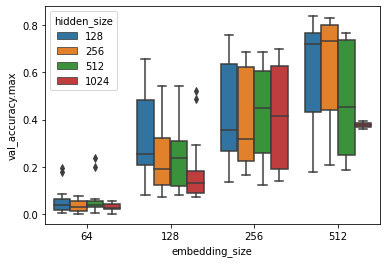

In [4]:
import seaborn as sns
embed_sizes = [64, 128, 256, 512,]
# df_64= df.loc[df["embedding_size"] == embed_sizes[0]]
# embed_sizes
sns.boxplot(data=df, x="embedding_size", y="val_accuracy.max", hue="hidden_size")

<AxesSubplot:xlabel='hidden_size', ylabel='val_accuracy.max'>

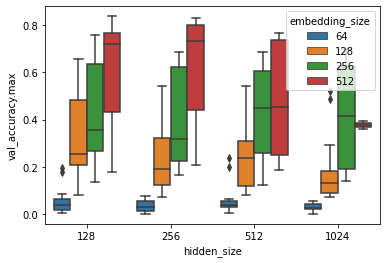

In [5]:
sns.boxplot(data=df, x="hidden_size", y="val_accuracy.max", hue="embedding_size")

<AxesSubplot:xlabel='hidden_size', ylabel='val_accuracy.max'>

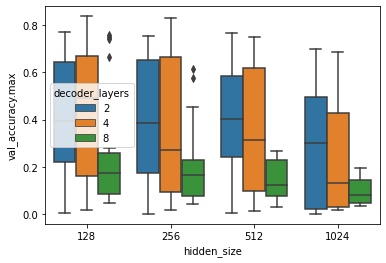

In [6]:
sns.boxplot(data=df, x="hidden_size", y="val_accuracy.max", hue="decoder_layers")

<AxesSubplot:xlabel='embedding_size', ylabel='val_accuracy.max'>

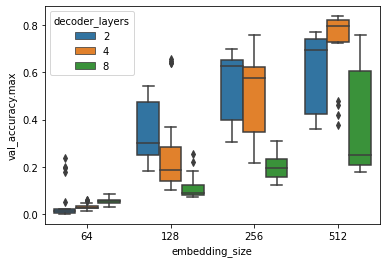

In [24]:
sns.boxplot(data=df, x="embedding_size", y="val_accuracy.max", hue="decoder_layers")

<AxesSubplot:xlabel='embedding_size', ylabel='val_accuracy.max'>

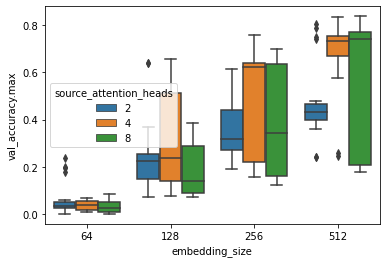

In [7]:
sns.boxplot(data=df, x="embedding_size", y="val_accuracy.max", hue="source_attention_heads")

<AxesSubplot:xlabel='hidden_size', ylabel='val_accuracy.max'>

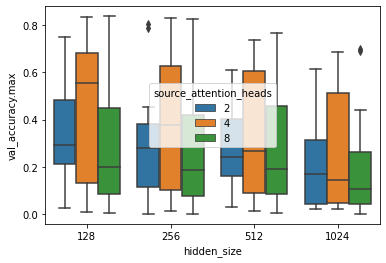

In [8]:
sns.boxplot(data=df, x="hidden_size", y="val_accuracy.max", hue="source_attention_heads")

<AxesSubplot:xlabel='hidden_size', ylabel='val_accuracy.max'>

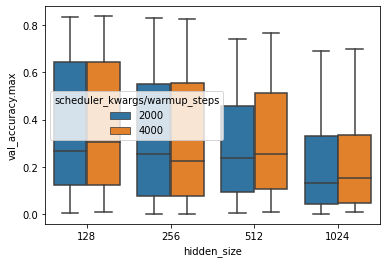

In [9]:
sns.boxplot(data=df, x="hidden_size", y="val_accuracy.max", hue="scheduler_kwargs/warmup_steps")

<AxesSubplot:xlabel='hidden_size', ylabel='val_accuracy.max'>

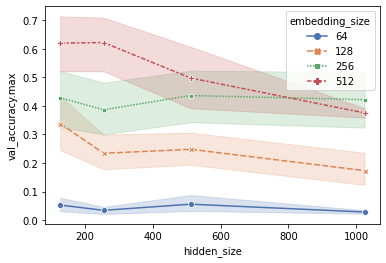

In [10]:
sns.lineplot(data=df, x="hidden_size", y="val_accuracy.max", estimator="mean", palette="deep", hue="embedding_size", style="embedding_size", markers=True)

<ipython-input-11-376ecd78cefd>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.lineplot(data=df, x="params", y="val_accuracy.max", estimator="mean", palette="deep", markers=True)


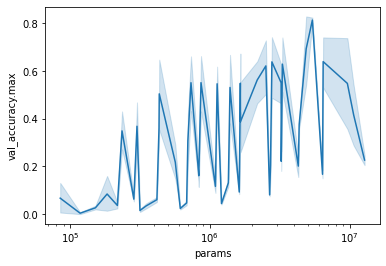

In [11]:
# g = sns.lineplot(data=df, x="params", y="val_accuracy.max", estimator="mean", palette="deep", hue="source_attention_heads", style="source_attention_heads", markers=True)
g = sns.lineplot(data=df, x="params", y="val_accuracy.max", estimator="mean", palette="deep", markers=True)
g.set_xscale("log")

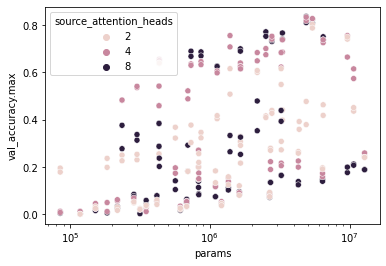

In [12]:
g = sns.scatterplot(data=df, x="params", y="val_accuracy.max", hue="source_attention_heads")
g.set_xscale("log")

# Encoder Decoder

In [13]:
import pandas as pd
from collections import Counter

ed_df = pd.read_csv("data/2023-ed-deu-sweep.csv")
ed_df["arch_name"] = "encoder-decoder"
# Ignore single attention head case
ed_df = ed_df.loc[ed_df["source_attention_heads"] > 1]
print(len(ed_df), len(set(ed_df["Name"])))
ed_df.head(10)

292 1


,Name,val_accuracy.max,scheduler_kwargs/warmup_steps,hidden_size,embedding_size,decoder_layers,source_attention_heads,State,Notes,User,...,source_vocab_size,start_idx,target_vocab_size,teacher_forcing,epoch,lr-Adam,train_loss,trainer/global_step,val_loss,arch_name
0,deu.trn,0.845,4000,256,256,4,4,finished,-,adamits,...,89,2,65,True,799,0.000447,0.736506,19999,1.053820,encoder-decoder
1,deu.trn,0.845,2000,128,512,4,2,finished,-,adamits,...,89,2,65,True,799,0.000316,0.738799,19999,1.020221,encoder-decoder
2,deu.trn,0.843,4000,128,256,2,4,finished,-,adamits,...,89,2,65,True,799,0.000447,0.748367,19999,1.073050,encoder-decoder
3,deu.trn,0.842,4000,256,128,4,2,finished,-,adamits,...,89,2,65,True,799,0.000447,0.747324,19999,1.054646,encoder-decoder
4,deu.trn,0.842,4000,1024,256,8,2,finished,-,adamits,...,89,2,65,True,799,0.000447,0.733510,19999,1.050185,encoder-decoder
5,deu.trn,0.842,4000,256,256,8,2,finished,-,adamits,...,89,2,65,True,799,0.000447,0.735458,19999,1.029633,encoder-decoder
6,deu.trn,0.841,4000,128,512,4,8,finished,-,adamits,...,89,2,65,True,799,0.000447,0.737855,19999,1.039829,encoder-decoder
7,deu.trn,0.840,2000,256,512,4,2,finished,-,adamits,...,89,2,65,True,799,0.000316,0.736618,19999,1.036329,encoder-decoder
8,deu.trn,0.840,4000,128,512,4,2,finished,-,adamits,...,89,2,65,True,799,0.000447,0.740061,19999,1.048299,encoder-decoder
9,deu.trn,0.840,2000,256,512,4,4,finished,-,adamits,...,89,2,65,True,799,0.000316,0.736526,19999,1.091882,encoder-decoder


In [14]:
ed_df["params"] = ed_df.apply(compute_num_params, axis=1)
ed_df.loc[
    (ed_df["decoder_layers"] == 4) &
    (ed_df["source_attention_heads"] == 4) &
    (ed_df["hidden_size"] == 1024)
]

,Name,val_accuracy.max,scheduler_kwargs/warmup_steps,hidden_size,embedding_size,decoder_layers,source_attention_heads,State,Notes,User,...,start_idx,target_vocab_size,teacher_forcing,epoch,lr-Adam,train_loss,trainer/global_step,val_loss,arch_name,params
29,deu.trn,0.835,2000,1024,256,4,4,finished,-,adamits,...,2,65,True,799,0.000316,0.734820,19999,1.052014,encoder-decoder,7514624
33,deu.trn,0.833,2000,1024,128,4,4,finished,-,adamits,...,2,65,True,799,0.000316,0.736809,19999,1.166312,encoder-decoder,2974976
37,deu.trn,0.831,4000,1024,128,4,4,finished,-,adamits,...,2,65,True,799,0.000447,0.737461,19999,1.129280,encoder-decoder,2974976
52,deu.trn,0.829,4000,1024,256,4,4,finished,-,adamits,...,2,65,True,799,0.000447,0.734809,19999,1.063812,encoder-decoder,7514624
131,deu.trn,0.814,2000,1024,512,4,4,finished,-,adamits,...,2,65,True,799,0.000316,0.735434,19999,1.104566,encoder-decoder,21312512
135,deu.trn,0.813,4000,1024,512,4,4,finished,-,adamits,...,2,65,True,799,0.000447,0.738096,19999,1.114347,encoder-decoder,21312512
175,deu.trn,0.805,2000,1024,512,4,4,crashed,-,adamits,...,2,65,True,386,0.000455,0.741127,9675,1.162746,encoder-decoder,21312512
228,deu.trn,0.787,4000,1024,64,4,4,finished,-,adamits,...,2,65,True,799,0.000447,0.749304,19999,1.109284,encoder-decoder,1294976
231,deu.trn,0.786,2000,1024,64,4,4,finished,-,adamits,...,2,65,True,799,0.000316,0.749351,19999,1.101968,encoder-decoder,1294976


<AxesSubplot:xlabel='embedding_size', ylabel='val_accuracy.max'>

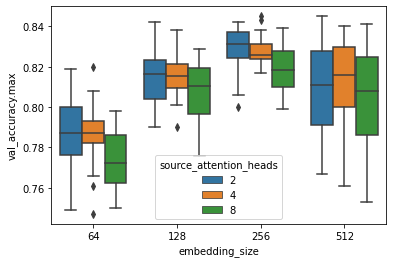

In [16]:
import seaborn as sns
sns.boxplot(data=ed_df, x="embedding_size", y="val_accuracy.max", hue="source_attention_heads")

<AxesSubplot:xlabel='hidden_size', ylabel='val_accuracy.max'>

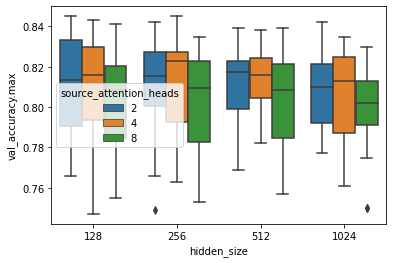

In [17]:
sns.boxplot(data=ed_df, x="hidden_size", y="val_accuracy.max", hue="source_attention_heads")

<AxesSubplot:xlabel='hidden_size', ylabel='val_accuracy.max'>

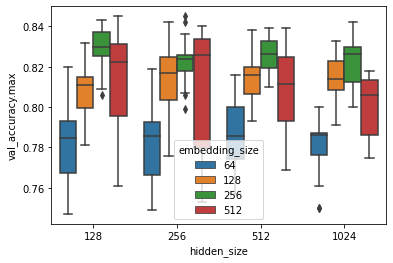

In [18]:
sns.boxplot(data=ed_df, x="hidden_size", y="val_accuracy.max", hue="embedding_size")

<AxesSubplot:xlabel='hidden_size', ylabel='val_accuracy.max'>

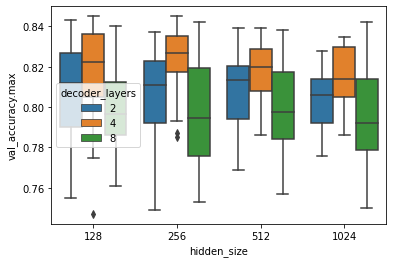

In [19]:
sns.boxplot(data=ed_df, x="hidden_size", y="val_accuracy.max", hue="decoder_layers")

<AxesSubplot:xlabel='embedding_size', ylabel='val_accuracy.max'>

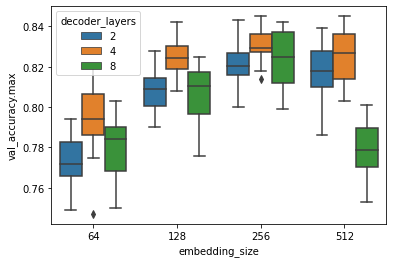

In [23]:
sns.boxplot(data=ed_df, x="embedding_size", y="val_accuracy.max", hue="decoder_layers")

<AxesSubplot:xlabel='hidden_size', ylabel='val_accuracy.max'>

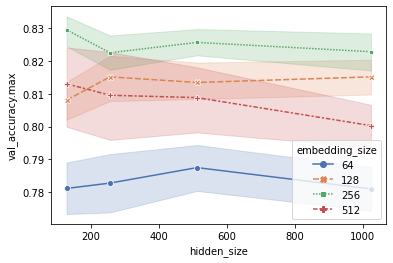

In [20]:
sns.lineplot(data=ed_df, x="hidden_size", y="val_accuracy.max", estimator="mean", palette="deep", hue="embedding_size", style="embedding_size", markers=True)

<ipython-input-21-2958a0ec64c0>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.lineplot(data=ed_df, x="params", y="val_accuracy.max", estimator="mean", palette="deep",  markers=True)


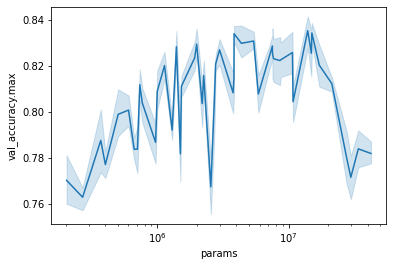

In [21]:
# g = sns.lineplot(data=ed_df, x="params", y="val_accuracy.max", estimator="mean", palette="deep", hue="source_attention_heads", style="source_attention_heads", markers=True)
g = sns.lineplot(data=ed_df, x="params", y="val_accuracy.max", estimator="mean", palette="deep",  markers=True)
g.set_xscale("log")

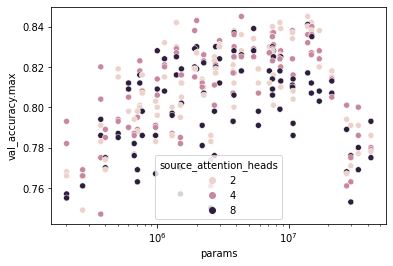

In [22]:
g = sns.scatterplot(data=ed_df, x="params", y="val_accuracy.max", hue="source_attention_heads")
g.set_xscale("log")